In [2]:
! /opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/bin/python -m pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 187.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 404.3 kB/s eta 0:00:00a 0:00:01


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import ImageDraw
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
import os
import multiprocessing
from PIL import Image

train_on_gpu = True

Path = 'histopathologic-cancer-detection/'

In [5]:
train_df = pd.read_csv(Path + 'train_labels.csv')
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
df_samples = pd.read_csv(Path + 'sample_submission.csv')
train = "histopathologic-cancer-detection/train/"
test = "histopathologic-cancer-detection/test"

print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


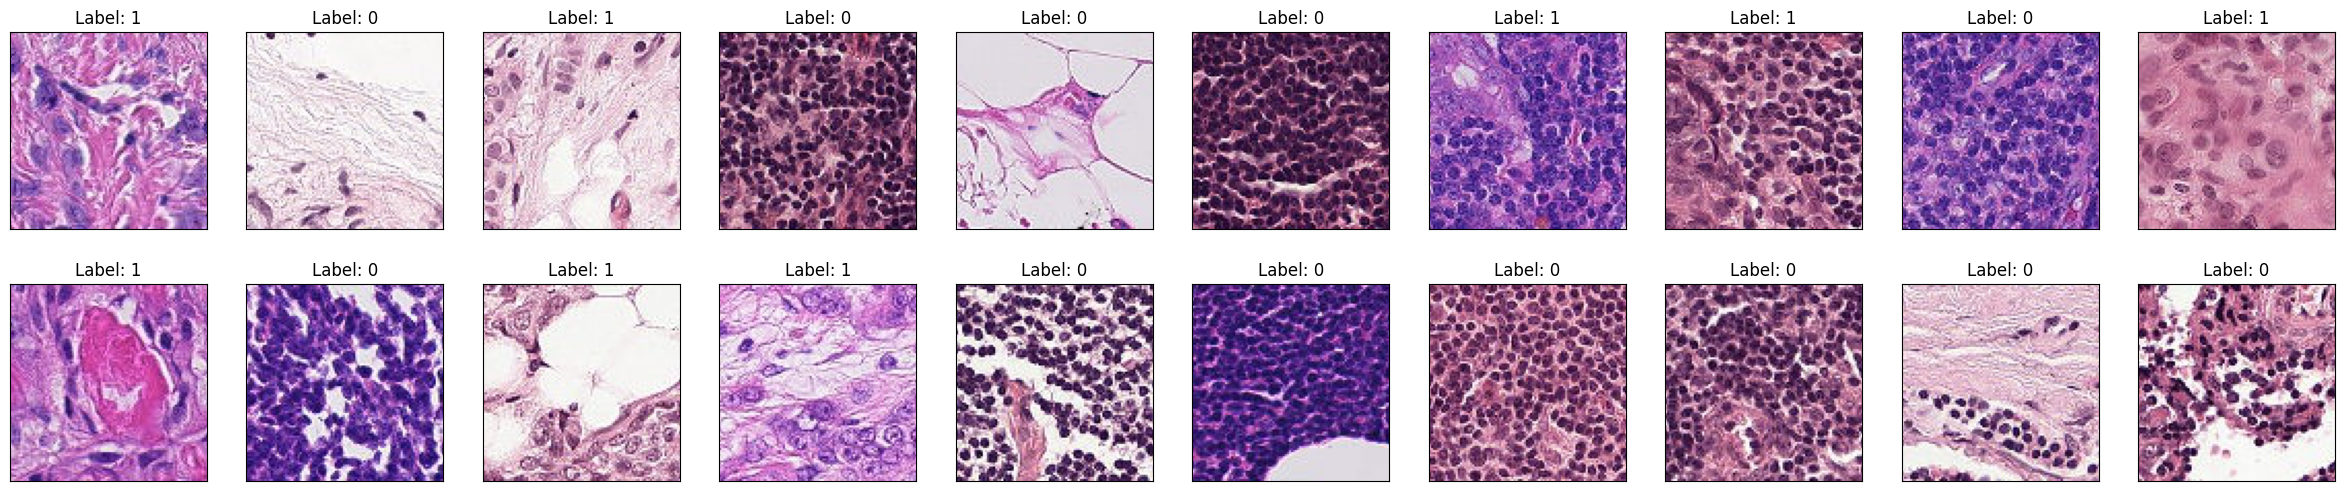

In [8]:
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(Path+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(Path+"train/" + img)
    plt.imshow(im)
    label = train_df.loc[train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {label}')

In [9]:
missing = train_df.isnull().sum()
print(missing)
print(np.array(im).shape)
print(train_df.shape)
print(train_df.columns)
print(train_df['label'].value_counts())

id       0
label    0
dtype: int64

<Axes: ylabel='count'>

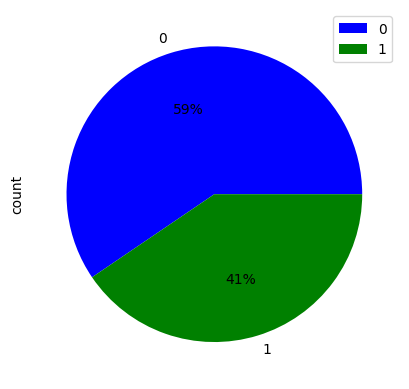

In [50]:
train_df['label'].value_counts().plot(kind='pie', legend=True, autopct='%1.0f%%', colors=['blue', 'green'])

In [51]:
def convert_image(image_file, label=0, with_label=True, subset='train'):
    image_name = image_file.split('.')[0]
    
    if with_label:
        output_dir = f'png/{subset}/{label}'
    else:
        output_dir = f'png/{subset}'

    os.makedirs(output_dir, exist_ok=True)

    output_path = f'{output_dir}/{image_name}.png'
    if not os.path.exists(output_path):
        with Image.open(Path + f'{subset}/{image_file}') as tiff_img:
            png = tiff_img.convert("RGB")
            png.save(output_path)

In [52]:
def convert_image_wrapper(args):
    return convert_image(*args)

def process_images(image_files, labels=[], with_label=True, subset='train'):
    tasks = [(filename, labels[index] if with_label else 0, with_label, subset) for index, filename in enumerate(image_files)]
    for task in tqdm(tasks):
        convert_image_wrapper(task)

In [21]:
process_images((train_df['id']+'.tif').values.tolist(), labels=train_df['label'].values.tolist())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 220025/220025 [07:22<00:00, 496.72it/s]


In [22]:
process_images(os.listdir(Path+"test"), with_label=False, subset='test')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 57458/57458 [01:47<00:00, 535.60it/s]


In [24]:
train_dataset = tf.keras.utils.image_dataset_from_directory('png/train', 
                                                            label_mode='binary',
                                                            image_size=(96,96), 
                                                            seed=42,
                                                            validation_split=0.2,
                                                            subset='training',
                                                            batch_size=128)

val_dataset = tf.keras.utils.image_dataset_from_directory('png/train', 
                                                            label_mode='binary',
                                                            image_size=(96,96), 
                                                            seed=42,
                                                            validation_split=0.2,
                                                            subset='validation',
                                                            batch_size=128)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


In [25]:
# Reading the test dataset:
test_dataset = tf.keras.utils.image_dataset_from_directory('png/test',
                                                            label_mode=None,
                                                            image_size=(96,96),
                                                            shuffle=False,
                                                            batch_size=1)

Found 57458 files.


In [26]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(96,96,3)))
model.add(layers.Conv2D(32, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

/opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,473 (458.88 KB)

 Trainable params: 117,473 (458.88 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
image_height=96
image_width=96
num_channels=3

# Define the CNN architecture
model = Sequential([
    # Convolutional layer with 32 filters, each 3x3 in size, using ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)),
    # Max pooling layer with a pool size of 2x2
    MaxPooling2D((2, 2)),
    
    # Convolutional layer with 64 filters, each 3x3 in size, using ReLU activation
    Conv2D(64, (3, 3), activation='relu'),
    # Max pooling layer with a pool size of 2x2
    MaxPooling2D((2, 2)),
    
    # Convolutional layer with 128 filters, each 3x3 in size, using ReLU activation
    Conv2D(128, (3, 3), activation='relu'),
    # Max pooling layer with a pool size of 2x2
    MaxPooling2D((2, 2)),
    
    # Flatten layer to convert 3D feature maps to 1D feature vectors
    Flatten(),
    
    # Fully connected (dense) layer with 128 neurons, using ReLU activation
    Dense(128, activation='relu'),
    
    # Output layer with softmax activation for multiclass classification
    Dense(1, activation='sigmoid')  # 5 types of rice
])

In [38]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [39]:
history = model.fit(train_dataset, epochs=3, validation_data=val_dataset)


Epoch 1/3
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 359s 261ms/step - accuracy: 0.7638 - loss: 3.4958 - val_accuracy: 0.8067 - val_loss: 0.4217
Epoch 2/3
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 360s 262ms/step - accuracy: 0.8150 - loss: 0.4128 - val_accuracy: 0.8347 - val_loss: 0.3721
Epoch 3/3
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 358s 260ms/step - accuracy: 0.8442 - loss: 0.3583 - val_accuracy: 0.8138 - val_loss: 0.4263


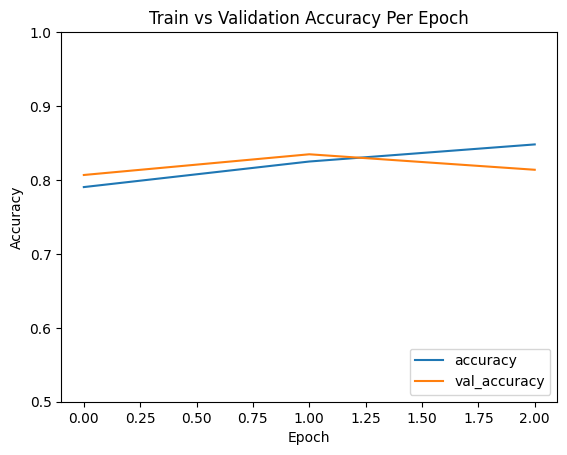

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Train vs Validation Accuracy Per Epoch')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Train vs Validation Loss Per Epoch')

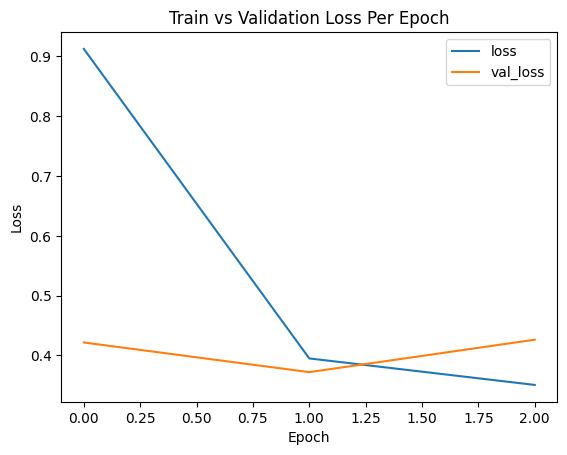

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')

In [42]:
test_images = os.listdir("png/test")
sub_pred_df = pd.DataFrame(columns=['id', 'label'])
test_images=sorted(test_images)

In [43]:
predictions = model.predict(test_dataset)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 145s 3ms/step


In [44]:
sub_pred_df['id'] = [filename.split('.')[0] for filename in test_images]
sub_pred_df['label'] = np.round(predictions.flatten()).astype('int')
sub_pred_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [45]:
!rm -r "png"

In [46]:
from glob import glob

files = []
for file in glob("histopathologic-cancer-detection/test/*.tif"):
    files.append(file)
files[0]

'histopathologic-cancer-detection/test/fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif'

In [47]:
SAMPLE_SUB = 'histopathologic-cancer-detection/sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)
len(sample_list)

57458

In [48]:
pred_dict = dict((key, value) for (key, value) in zip(sub_pred_df.id, sub_pred_df.label))
pred_corr = [pred_dict[id] for id in sample_list]
submission_df = pd.DataFrame({"id": sample_list, "label": pred_corr})
submission_df.to_csv("submission.csv", header=True, index=False)